In [2]:
import pandas as pd
import requests
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import PIL.Image
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import PIL.Image
from torch import nn
from transformers import ViTModel, ViTFeatureExtractor, ViTConfig
import torch.optim as optim
from tqdm import tqdm
from evaluations.kaggle_2020 import global_average_precision_score

In [3]:
BASE_PATH = "/home/david/Downloads/landmark-recognition-2021"

train_df = pd.read_csv(BASE_PATH + "/train.csv")

In [4]:
print(train_df.shape)

(1580470, 2)


In [5]:
print(train_df.head())

                 id  landmark_id
0  17660ef415d37059            1
1  92b6290d571448f6            1
2  cd41bf948edc0340            1
3  fb09f1e98c6d2f70            1
4  25c9dfc7ea69838d            7


In [6]:
def image_grid3x3(image_array, landmarks):
    fig = plt.figure(figsize=(12., 12.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(3, 3),
                     axes_pad=1)
    
    for idx, (ax, im) in enumerate(zip(grid, image_array)):
        ax.imshow(im)
        ax.set_title(landmarks[idx])
        ax.set_xlabel(f'{im.shape}')
        
    plt.show()

In [7]:
def make_img_path(img_id):
    return "/".join([char for char in img_id[:3]]) + "/" + img_id + ".jpg"

In [8]:
def get_img_numpy(img_id, base="/train"):
    img_path = make_img_path(img_id)
    print(base + "/" + img_path)
    img = Image.open(base + "/" + img_path)
    return np.asarray(img)

/home/david/Downloads/landmark-recognition-2021/train/d/e/8/de8aea5b2509a9cb.jpg
/home/david/Downloads/landmark-recognition-2021/train/0/8/3/083d66c51b843699.jpg
/home/david/Downloads/landmark-recognition-2021/train/1/4/3/1437a17f7807b1aa.jpg
/home/david/Downloads/landmark-recognition-2021/train/1/e/a/1eabd249a553256b.jpg
/home/david/Downloads/landmark-recognition-2021/train/1/f/5/1f57b35a5f1f2701.jpg
/home/david/Downloads/landmark-recognition-2021/train/2/9/f/29f1cd45da7ba3e9.jpg
/home/david/Downloads/landmark-recognition-2021/train/3/3/6/3361c759a1fca3ae.jpg
/home/david/Downloads/landmark-recognition-2021/train/4/6/1/4617eedec24cc1f3.jpg
/home/david/Downloads/landmark-recognition-2021/train/4/8/7/4871d98dfc997c59.jpg


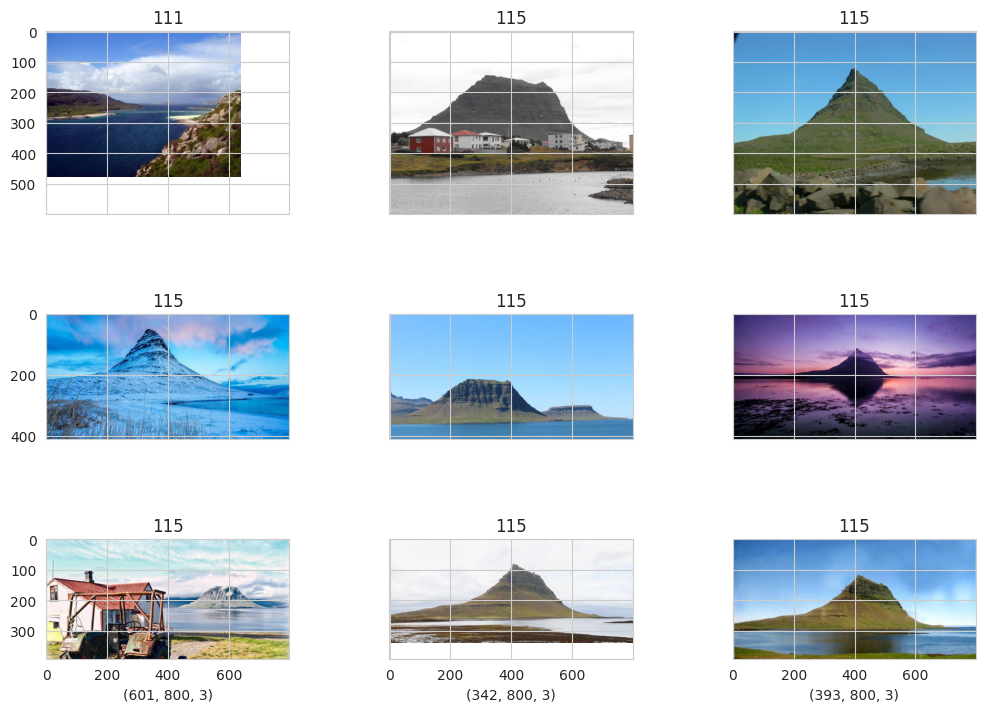

In [9]:
img_array = [get_img_numpy(img, BASE_PATH + "/train") for img in train_df['id'][1000:1009]]

image_grid3x3(img_array, [landmark for landmark in train_df['landmark_id'][1000:1009]])

/home/david/Downloads/landmark-recognition-2021/train/8/b/2/8b23ddb661705113.jpg
/home/david/Downloads/landmark-recognition-2021/train/9/0/3/903fc30c8f64e54a.jpg
/home/david/Downloads/landmark-recognition-2021/train/9/0/8/908bbaeb8b0fa889.jpg
/home/david/Downloads/landmark-recognition-2021/train/9/2/7/92787607a02f838f.jpg
/home/david/Downloads/landmark-recognition-2021/train/9/5/8/9586486b0fcd7e01.jpg
/home/david/Downloads/landmark-recognition-2021/train/9/c/1/9c1bbbcf25812ba3.jpg
/home/david/Downloads/landmark-recognition-2021/train/9/d/a/9da3cbf6d8b52854.jpg
/home/david/Downloads/landmark-recognition-2021/train/a/2/1/a213a63899e5388f.jpg
/home/david/Downloads/landmark-recognition-2021/train/a/2/f/a2f1fa237f7a14da.jpg


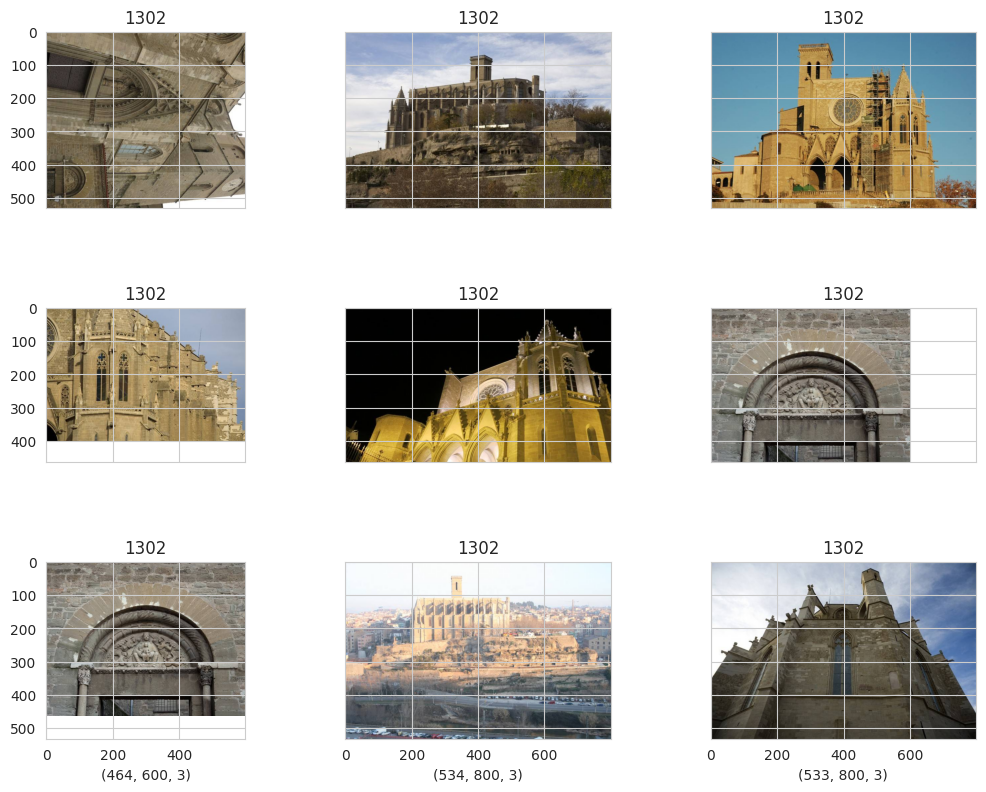

In [10]:
img_array = [get_img_numpy(img, BASE_PATH + "/train") for img in train_df['id'][10000:10009]]

image_grid3x3(img_array, [landmark for landmark in train_df['landmark_id'][10000:10009]])

<Axes: xlabel='landmark_id', ylabel='Count'>

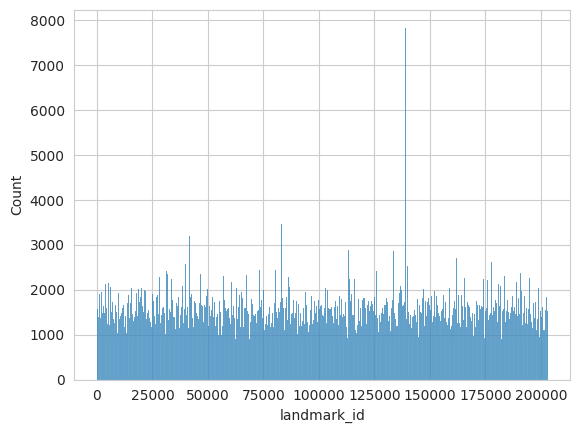

In [11]:
sns.histplot(data=train_df, x="landmark_id", bins=1000)

In [58]:
def fetch_landmarks_by_country(country_code):
    country_url = f"https://storage.googleapis.com/gld-v2/data/train/country/{country_code}.json"
    response = requests.get(country_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data for country {country_code}")
    
    landmarks = response.json()
    return landmarks

def fetch_images_by_landmark(landmark_id):
    landmark_url = f"https://storage.googleapis.com/gld-v2/data/train/landmarks/{landmark_id}.json"
    response = requests.get(landmark_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch images for landmark {landmark_id}")
    
    images_data = response.json()
    return images_data['images']

def main(country_code):
    landmarks = fetch_landmarks_by_country(country_code)
    
    result = []
    for landmark in landmarks:
        landmark_id = landmark['id']
        landmark_name = landmark['name']
        images = fetch_images_by_landmark(landmark_id)
        image_urls = [image['url'] for image in images]
        
        result.append({
            'id': landmark_id,
            'name': landmark_name,
            'images': image_urls
        })
    
    return result

# # Example usage:
# country_code = 'BG'
# landmark_data = main(country_code)
# for data in landmark_data:
#     print(f"Landmark ID: {data['id']}, Name: {data['name']}, Images: {data['images']}")

In [64]:

def fetch_landmarks_by_country_list(codes):
    """
    Fetches landmark IDs for a list of country codes.

    Args:
    - codes (list): List of two-letter country codes.

    Returns:
    - list: Combined list of landmark IDs.
    """
    all_landmarks = []

    for country_code in codes:
        country_url = f"https://storage.googleapis.com/gld-v2/data/train/country/{country_code}.json"
        response = requests.get(country_url)
        if response.status_code != 200:
            raise Exception(f"Failed to fetch data for country {country_code}")
        
        landmarks = response.json()
        all_landmarks.extend(landmarks)
    
    return all_landmarks

In [65]:
all_landmarks = fetch_landmarks_by_country_list(["BG", "FR"])

In [67]:
all_landmarks

[{'id': 20298, 'name': 'Church_of_the_Holy_Saviour,_Nesebar'},
 {'id': 19441, 'name': 'Dohodno_Zdanie'},
 {'id': 19459, 'name': 'Tsarichina'},
 {'id': 19047, 'name': "Eagles'_Bridge,_Sofia"},
 {'id': 19053, 'name': 'Ropotamo_(nature_reserve)'},
 {'id': 21888, 'name': 'Church_of_Saint_Nicholas,_Vukovo'},
 {'id': 21874, 'name': 'Stara_Zagora_Neolithic_Dwellings'},
 {'id': 21235, 'name': 'Likana'},
 {'id': 21536, 'name': 'Sopot_Monastery'},
 {'id': 21153, 'name': '%C5%9Eahabettin_%C4%B0maret_Mosque'},
 {'id': 22995, 'name': 'Balabana'},
 {'id': 22102, 'name': 'Klisura_Monastery,_Sofia_Eparchy'},
 {'id': 25025, 'name': 'Large_basilica,_Plovdiv'},
 {'id': 24606, 'name': 'Shumen_Plateau'},
 {'id': 23567, 'name': 'Dechkova_house'},
 {'id': 23894, 'name': 'Storgosia'},
 {'id': 13644, 'name': 'Vratsata_Gorge'},
 {'id': 13161, 'name': 'Vrachanski_Karst'},
 {'id': 15287, 'name': 'Lake_Burgas'},
 {'id': 14844, 'name': 'Kaylaka'},
 {'id': 14943, 'name': 'Stara_Zagora_Zoo'},
 {'id': 17118, 'name': '

In [80]:
df = pd.DataFrame(all_landmarks)

# Rename the id column to landmark_id
df = df.rename(columns={'id': 'landmark_id'})

# Select only the landmark_id column
df_landmark_ids = df[['landmark_id']]

# Save the DataFrame to a CSV file
df_landmark_ids.to_csv('eu_landmarks.csv',sep='\t', index=False)

In [56]:
country_code = 'BG'

In [59]:
landmarks = fetch_landmarks_by_country(country_code)

In [61]:
landmarks

[{'id': 20298, 'name': 'Church_of_the_Holy_Saviour,_Nesebar'},
 {'id': 19441, 'name': 'Dohodno_Zdanie'},
 {'id': 19459, 'name': 'Tsarichina'},
 {'id': 19047, 'name': "Eagles'_Bridge,_Sofia"},
 {'id': 19053, 'name': 'Ropotamo_(nature_reserve)'},
 {'id': 21888, 'name': 'Church_of_Saint_Nicholas,_Vukovo'},
 {'id': 21874, 'name': 'Stara_Zagora_Neolithic_Dwellings'},
 {'id': 21235, 'name': 'Likana'},
 {'id': 21536, 'name': 'Sopot_Monastery'},
 {'id': 21153, 'name': '%C5%9Eahabettin_%C4%B0maret_Mosque'},
 {'id': 22995, 'name': 'Balabana'},
 {'id': 22102, 'name': 'Klisura_Monastery,_Sofia_Eparchy'},
 {'id': 25025, 'name': 'Large_basilica,_Plovdiv'},
 {'id': 24606, 'name': 'Shumen_Plateau'},
 {'id': 23567, 'name': 'Dechkova_house'},
 {'id': 23894, 'name': 'Storgosia'},
 {'id': 13644, 'name': 'Vratsata_Gorge'},
 {'id': 13161, 'name': 'Vrachanski_Karst'},
 {'id': 15287, 'name': 'Lake_Burgas'},
 {'id': 14844, 'name': 'Kaylaka'},
 {'id': 14943, 'name': 'Stara_Zagora_Zoo'},
 {'id': 17118, 'name': '

In [16]:
def extract_image_ids(landmark_data):
    image_ids = []
    for data in landmark_data:
        image_ids.extend(data['images'])
    return image_ids

def extract_landark_ids_list(landmark_data):
    landmark_ids = []
    for data in landmark_data:
        landmark_ids.append(data['id'])
    return landmark_ids

In [6]:
bg_landmarks_ids = extract_landark_ids_list(landmark_data)
bg_landmarks_ids = pd.read_csv("bg_landmarks_ids.csv", sep='\t')
bg_landmarks_ids

,landmark_id
0,20298
1,19441
2,19459
3,19047
4,19053
...,...
653,183360
654,183612
655,182985
656,182554


In [7]:
len(bg_landmarks_ids)

658

In [8]:
def read_csv_to_dict(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Convert the DataFrame to a dictionary
    landmark_dict = df.set_index('landmark_id')['category'].to_dict()
    
    return landmark_dict

In [9]:
# Example usage:
csv_file_path = BASE_PATH + '/train_label_to_category.csv'  # Replace with the path to your CSV file
landmark_id_to_wikimedia = read_csv_to_dict(csv_file_path)

In [10]:
print(len(landmark_id_to_wikimedia))

203094


In [11]:
list(landmark_id_to_wikimedia.items())[:5]

[(0, 'http://commons.wikimedia.org/wiki/Category:Happy_Valley_Racecourse'),
 (1, 'http://commons.wikimedia.org/wiki/Category:Luitpoldpark_in_Munich'),
 (2, 'http://commons.wikimedia.org/wiki/Category:Grand_Ventron'),
 (3,
  'http://commons.wikimedia.org/wiki/Category:Tweed_Heads,_New_South_Wales'),
 (4,
  'http://commons.wikimedia.org/wiki/Category:Santa_Maria_Immacolata_della_Concezione_(Rome)')]

In [12]:
device = torch.device("cuda")
device

device(type='cuda')

In [13]:
wikimedia_to_landmark_id = {v: k for k, v in landmark_id_to_wikimedia.items()}

In [14]:
list(wikimedia_to_landmark_id.items())[:5]

[('http://commons.wikimedia.org/wiki/Category:Happy_Valley_Racecourse', 0),
 ('http://commons.wikimedia.org/wiki/Category:Luitpoldpark_in_Munich', 1),
 ('http://commons.wikimedia.org/wiki/Category:Grand_Ventron', 2),
 ('http://commons.wikimedia.org/wiki/Category:Tweed_Heads,_New_South_Wales',
  3),
 ('http://commons.wikimedia.org/wiki/Category:Santa_Maria_Immacolata_della_Concezione_(Rome)',
  4)]

In [15]:
train_df

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092


In [16]:
lid = train_df.iloc[0]['landmark_id']
lid

1

In [17]:
train_df.head(10)

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
5,28b13f94a6f1f3c1,7
6,307d6584f473ba35,7
7,4a7ba9eb16d51bc4,7
8,597353dfbb3df649,7
9,a40d00dc4fcc3a10,7


In [18]:
landmark_id_to_wikimedia[481]

'http://commons.wikimedia.org/wiki/Category:Bayrakli_Mosque,_Samokov'

In [19]:
bg_landmarks_ids[0:10]

,landmark_id
0,20298
1,19441
2,19459
3,19047
4,19053
5,21888
6,21874
7,21235
8,21536
9,21153


In [20]:
len(bg_landmarks_ids)

658

In [21]:
# Function to check if landmark_id maps to a bg_image_id
def is_in_bg_image_ids(landmark_id, bg_landmarks_ids):
    return landmark_id in bg_landmarks_ids.values

In [22]:
is_in_bg_image_ids(20298,bg_landmarks_ids)

True

In [23]:
bg_train_df = train_df[train_df['landmark_id'].apply(lambda lid: is_in_bg_image_ids(lid, bg_landmarks_ids))]
bg_train_df

,id,landmark_id
3959,4db638f8d0dc1ce2,481
3960,4e454120ba3bfb36,481
3961,69ba8a4a5ecc9c61,481
3962,81dc5e647b5e9c8b,481
3963,a893e44faf1e9640,481
...,...,...
1580097,c58c445a89cc7ca9,203034
1580098,c9d6a8aa86d1fce5,203034
1580099,cc4cfcfce95fc633,203034
1580100,e48bf94f91142d96,203034


In [24]:
class CustomCountryDataset(Dataset):
    def __init__(self, photo_label_df, path, transform):
        self.photo_label_df = photo_label_df
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.photo_label_df)
    
    def __getitem__(self, index):
        row = self.photo_label_df.iloc[index]
        image_id = row['id']
        landmark_id_index = row['label_index']  # Use the label index
        file = image_id + '.jpg'
        subpath = '/'.join([char for char in image_id[0:3]])

        image = PIL.Image.open(self.path + '/' + subpath + '/' + file)
        X = self.transform(image)
        y = torch.tensor(landmark_id_index, dtype=torch.long)
        
        return X, y

In [25]:
transform_to_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [26]:
image_id = bg_train_df.iloc[0]['id']
file = image_id + '.jpg'
subpath = '/'.join([char for char in image_id[0:3]])
fullPath = BASE_PATH + '/train' + '/' + subpath + '/' + file
image = PIL.Image.open(fullPath)
image = transform_to_128(image)
image.shape

torch.Size([3, 128, 128])

In [27]:
bg_train_df.iloc[0]['landmark_id']

481

In [28]:
len(bg_train_df)

9418

In [29]:
unique_classes = bg_train_df['landmark_id'].unique()
print(len(unique_classes))

label_to_index = {label: idx for idx, label in enumerate(unique_classes)}

bg_train_with_index = pd.DataFrame(bg_train_df)
bg_train_with_index['label_index'] = bg_train_with_index['landmark_id'].map(label_to_index)
bg_train_with_index

339


,id,landmark_id,label_index
3959,4db638f8d0dc1ce2,481,0
3960,4e454120ba3bfb36,481,0
3961,69ba8a4a5ecc9c61,481,0
3962,81dc5e647b5e9c8b,481,0
3963,a893e44faf1e9640,481,0
...,...,...,...
1580097,c58c445a89cc7ca9,203034,338
1580098,c9d6a8aa86d1fce5,203034,338
1580099,cc4cfcfce95fc633,203034,338
1580100,e48bf94f91142d96,203034,338


In [30]:
bg_train_df = bg_train_with_index

In [31]:
train_df, val_df = train_test_split(bg_train_df, test_size=0.1, random_state=42)
len(train_df), len(val_df)

(8476, 942)

In [32]:
unique_classes_train = train_df['label_index'].unique()
unique_classes_val = val_df['label_index'].unique()
len(unique_classes_train), len(unique_classes_val)

(338, 244)

In [33]:
train_df

,id,landmark_id,label_index
690104,e3863554281b5180,88483,156
1052611,b858c5811bf6d4d1,135891,225
430853,23c8a4dc1adda9ea,54373,91
274580,124a142a1dfcc696,35005,53
1501256,f60ec48f0f5efc70,192720,316
...,...,...,...
788725,06ab82130f89b024,101924,174
690082,d55841fd30d2a7e6,88483,156
746193,846830ebf5fb50bc,96275,164
74586,d55e4a70814cd8f7,9673,16


In [34]:
train_dataset = CustomCountryDataset(
    photo_label_df=train_df,
    path=BASE_PATH + '/train',
    transform=transform_to_128,
)

val_dataset = CustomCountryDataset(
    photo_label_df=val_df,
    path=BASE_PATH + '/train',
    transform=transform_to_128,
)

In [35]:
train_dataset[110][0]

tensor([[[-0.6794, -0.7308, -0.7308,  ..., -1.0562, -1.2445, -1.2617],
         [-0.3541, -0.4226, -0.5424,  ..., -0.9192, -1.1932, -1.1418],
         [-0.3712, -0.3027, -0.2513,  ..., -0.5938, -1.1075, -0.6794],
         ...,
         [-0.6281, -0.3883, -0.3027,  ..., -0.3541, -0.2856, -0.2856],
         [-0.3198, -0.2342, -0.1999,  ..., -0.6109, -0.5938, -0.5596],
         [-0.2684, -0.3027, -0.3541,  ..., -0.7822, -0.6623, -0.6452]],

        [[-1.2829, -1.3354, -1.3529,  ..., -1.3354, -1.4405, -1.4930],
         [-0.8803, -0.9678, -1.0903,  ..., -1.1604, -1.3354, -1.2829],
         [-1.0028, -0.9153, -0.8452,  ..., -0.8452, -1.3704, -1.0728],
         ...,
         [-0.7577, -0.5126, -0.4251,  ..., -0.8277, -0.7402, -0.6877],
         [-0.3901, -0.2850, -0.2675,  ..., -1.0378, -1.0378, -0.9853],
         [-0.3200, -0.3550, -0.4076,  ..., -1.0903, -1.0203, -1.0028]],

        [[-1.5081, -1.5604, -1.5604,  ..., -1.3687, -1.4036, -1.4733],
         [-1.1944, -1.2816, -1.4036,  ..., -1

In [36]:
batch_size = 8

In [37]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [38]:
class VisionTransformer(nn.Module):
    def __init__(self, num_labels):
        super(VisionTransformer, self).__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
        config.image_size = 128  # Set new image size
        config.patch_size = 8
        self.vit = ViTModel(config)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
    
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

In [39]:
# Initialize model
num_labels = len(train_df['landmark_id'].unique())
model = VisionTransformer(num_labels)

In [40]:
num_labels

338

In [41]:
model.to(device)

VisionTransformer(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [42]:
print("cuda available: " + str(torch.cuda.is_available()))

cuda available: True


In [43]:
from torchsummary import summary
summary(model.to(device), (3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─ViTModel: 1-1                          [[-1, 768]]               --
|    └─ViTEmbeddings: 2-1                [-1, 257, 768]            --
|    |    └─ViTPatchEmbeddings: 3-1      [-1, 256, 768]            148,224
|    |    └─Dropout: 3-2                 [-1, 257, 768]            --
|    └─ViTEncoder: 2-2                   [[-1, 257, 768]]          --
|    └─LayerNorm: 2-3                    [-1, 257, 768]            1,536
|    └─ViTPooler: 2-4                    [-1, 768]                 --
|    |    └─Linear: 3-3                  [-1, 768]                 590,592
|    |    └─Tanh: 3-4                    [-1, 768]                 --
├─Linear: 1-2                            [-1, 338]                 259,922
Total params: 1,000,274
Trainable params: 1,000,274
Non-trainable params: 0
Total mult-adds (M): 295.08
Input size (MB): 0.19
Forward/backward pass size (MB): 3.01
Params size (MB): 3.82
Estimated Total Size

Layer (type:depth-idx)                   Output Shape              Param #
├─ViTModel: 1-1                          [[-1, 768]]               --
|    └─ViTEmbeddings: 2-1                [-1, 257, 768]            --
|    |    └─ViTPatchEmbeddings: 3-1      [-1, 256, 768]            148,224
|    |    └─Dropout: 3-2                 [-1, 257, 768]            --
|    └─ViTEncoder: 2-2                   [[-1, 257, 768]]          --
|    └─LayerNorm: 2-3                    [-1, 257, 768]            1,536
|    └─ViTPooler: 2-4                    [-1, 768]                 --
|    |    └─Linear: 3-3                  [-1, 768]                 590,592
|    |    └─Tanh: 3-4                    [-1, 768]                 --
├─Linear: 1-2                            [-1, 338]                 259,922
Total params: 1,000,274
Trainable params: 1,000,274
Non-trainable params: 0
Total mult-adds (M): 295.08
Input size (MB): 0.19
Forward/backward pass size (MB): 3.01
Params size (MB): 3.82
Estimated Total Size

In [49]:
device

device(type='cuda')

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    valid_epoch_loss = running_loss / len(val_dataloader.dataset)
    val_losses.append(valid_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Valid loss: {valid_epoch_loss:.4f}')

Training loop: 100%|██████████| 67/67 [02:00<00:00,  1.80s/it]


Epoch 1/5, Loss: 4.0936
Epoch 1/5, Valid loss: 4.0936


Training loop: 100%|██████████| 67/67 [01:57<00:00,  1.76s/it]


Epoch 2/5, Loss: 3.7182
Epoch 2/5, Valid loss: 3.7182


Training loop: 100%|██████████| 67/67 [01:57<00:00,  1.75s/it]


Epoch 3/5, Loss: 3.4127
Epoch 3/5, Valid loss: 3.4127


Training loop: 100%|██████████| 67/67 [01:57<00:00,  1.76s/it]


Epoch 4/5, Loss: 3.0966
Epoch 4/5, Valid loss: 3.0966


Training loop: 100%|██████████| 67/67 [01:57<00:00,  1.75s/it]


Epoch 5/5, Loss: 2.7779
Epoch 5/5, Valid loss: 2.7779


In [57]:
# Validation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Validation Accuracy: 26.01%


In [44]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.title("Loss over epochs")
    plt.show()

In [54]:
plot_losses(train_losses, val_losses)

NameError: name 'train_losses' is not defined

In [51]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

In [61]:
predictions = get_predictions(model, val_dataloader, device)

In [62]:
val_df_with_predictions = pd.DataFrame(val_df)
val_df_with_predictions['prediction'] = predictions
val_df_with_predictions

,id,landmark_id,label_index,prediction
1228720,215ab4de52204abd,158317,261,261
74350,15bc7cb44b7c83fc,9673,16,16
1200403,9d0c421d104ef851,154455,251,16
333454,ce084423ce3c0e93,42083,67,148
1536216,6890547f2c2a4d96,197232,326,11
...,...,...,...,...
74492,8d73a258aba4f549,9673,16,16
333433,62cfbd8e61c030ff,42083,67,148
211338,f0077c25ceb081d0,27190,36,36
1163450,9afda41934581f69,149551,246,156


In [64]:
torch.save(model.state_dict(), "models/transformer-5-epochs-65-size-128-batch-size")

In [45]:
def calculate_gap(model, data_loader, train_labels, device):
    """
    Calculate the Global Average Precision (GAP) on the validation dataset.

    Args:
    - model (torch.nn.Module): The trained PyTorch model.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - train_labels (array): Unique indexes of landmarks of the training dataset
    - device (torch.device): The device to run the model on (CPU or CUDA).

    Returns:
    - float: GAP score.
    """
    model.eval()  # Set the model to evaluation mode

    all_predictions = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc='Evaluating model'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            confidences, predictions = torch.max(torch.softmax(outputs, dim=1), dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

    # Create a DataFrame to store predictions and labels
    df = pd.DataFrame({
        'label_index': all_labels,
        'prediction': all_predictions,
        'confidence': all_confidences
    })

    # Sort by confidence in descending order
    df_sorted = df.sort_values(by='confidence', ascending=False).reset_index(drop=False)

    # Initialize variables
    correct_predictions = 0
    total_relevant = 0
    gap = 0.0

    for i, row in df_sorted.iterrows():
        if row['label_index'] in train_labels:
            total_relevant += 1
            if row['label_index'] == row['prediction']:
                correct_predictions += 1
                precision_at_i = correct_predictions / total_relevant
                gap += precision_at_i

    gap /= total_relevant
    return gap, df_sorted

In [66]:
gap_score, df_with_confidence = calculate_gap(model, val_dataloader, unique_classes_train, device)
print(f"Global Average Precision (GAP): {gap_score:.4f}")

Evaluating model: 100%|██████████| 8/8 [00:13<00:00,  1.68s/it]

Global Average Precision (GAP): 0.1498


In [67]:
df_with_confidence

,index,label_index,prediction,confidence
0,402,11,11,0.987663
1,774,16,16,0.977661
2,745,11,11,0.970850
3,401,16,16,0.968181
4,899,16,16,0.958015
...,...,...,...,...
937,330,160,265,0.053510
938,717,171,36,0.050830
939,432,115,163,0.048154
940,505,22,165,0.043852


In [68]:
gap_score

0.14977478741760303

In [73]:
# Check correct implementation of GAP by comparing with evaluations.kaggle_2020 library
dict_true  = dict(zip(df_with_confidence['index'], df_with_confidence['label_index']))
dict_pred = {row['index']: [row['prediction'], row['confidence']] for _, row in df_with_confidence.iterrows()}
global_average_precision_score(dict_true, dict_pred)

0.14922820173628548

In [46]:
def train(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    
    # Training loop
    num_epochs = epochs
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_dataloader, desc='Training loop'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
        valid_epoch_loss = running_loss / len(val_dataloader.dataset)
        val_losses.append(valid_epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Valid loss: {valid_epoch_loss:.4f}')
    plot_losses(train_losses, val_losses)

In [49]:
# Initialize new model
num_labels = len(train_df['landmark_id'].unique())
model = VisionTransformer(num_labels)
model.to(device)

VisionTransformer(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [51]:
train(model, 40)

Training loop: 100%|██████████| 67/67 [01:57<00:00,  1.75s/it]


Epoch 1/40, Loss: 4.7972
Epoch 1/40, Valid loss: 4.5101


Training loop: 100%|██████████| 67/67 [01:55<00:00,  1.73s/it]


Epoch 2/40, Loss: 4.2506
Epoch 2/40, Valid loss: 4.2796


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.74s/it]


Epoch 3/40, Loss: 3.8677
Epoch 3/40, Valid loss: 4.0099


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.74s/it]


Epoch 4/40, Loss: 3.5809
Epoch 4/40, Valid loss: 3.8896


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.74s/it]


Epoch 5/40, Loss: 3.2673
Epoch 5/40, Valid loss: 3.6818


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.73s/it]


Epoch 6/40, Loss: 2.9313
Epoch 6/40, Valid loss: 3.5667


Training loop: 100%|██████████| 67/67 [01:55<00:00,  1.73s/it]


Epoch 7/40, Loss: 2.5996
Epoch 7/40, Valid loss: 3.5118


Training loop: 100%|██████████| 67/67 [01:55<00:00,  1.73s/it]


Epoch 8/40, Loss: 2.1883
Epoch 8/40, Valid loss: 3.4562


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 9/40, Loss: 1.7681
Epoch 9/40, Valid loss: 3.4506


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 10/40, Loss: 1.2494
Epoch 10/40, Valid loss: 3.4543


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 11/40, Loss: 0.7867
Epoch 11/40, Valid loss: 3.5261


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 12/40, Loss: 0.3649
Epoch 12/40, Valid loss: 3.4866


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 13/40, Loss: 0.1713
Epoch 13/40, Valid loss: 3.5760


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 14/40, Loss: 0.1051
Epoch 14/40, Valid loss: 3.5625


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 15/40, Loss: 0.0858
Epoch 15/40, Valid loss: 3.7098


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 16/40, Loss: 0.0558
Epoch 16/40, Valid loss: 3.6323


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.72s/it]


Epoch 17/40, Loss: 0.0331
Epoch 17/40, Valid loss: 3.6283


Training loop: 100%|██████████| 67/67 [01:55<00:00,  1.73s/it]


Epoch 18/40, Loss: 0.0278
Epoch 18/40, Valid loss: 3.6144


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.70s/it]


Epoch 19/40, Loss: 0.0147
Epoch 19/40, Valid loss: 3.6372


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 20/40, Loss: 0.0129
Epoch 20/40, Valid loss: 3.6606


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 21/40, Loss: 0.0115
Epoch 21/40, Valid loss: 3.6586


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 22/40, Loss: 0.0118
Epoch 22/40, Valid loss: 3.6381


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 23/40, Loss: 0.0284
Epoch 23/40, Valid loss: 3.8504


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 24/40, Loss: 0.1005
Epoch 24/40, Valid loss: 3.9447


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 25/40, Loss: 0.3146
Epoch 25/40, Valid loss: 4.0621


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 26/40, Loss: 0.2688
Epoch 26/40, Valid loss: 4.1252


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 27/40, Loss: 0.1349
Epoch 27/40, Valid loss: 4.0173


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 28/40, Loss: 0.0783
Epoch 28/40, Valid loss: 4.1048


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 29/40, Loss: 0.0701
Epoch 29/40, Valid loss: 4.0327


Training loop: 100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Epoch 30/40, Loss: 0.0727
Epoch 30/40, Valid loss: 3.9661


Training loop: 100%|██████████| 67/67 [01:55<00:00,  1.73s/it]


Epoch 31/40, Loss: 0.0364
Epoch 31/40, Valid loss: 3.9889


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.74s/it]


Epoch 32/40, Loss: 0.0176
Epoch 32/40, Valid loss: 4.0511


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.74s/it]


Epoch 33/40, Loss: 0.0138
Epoch 33/40, Valid loss: 4.0742


Training loop: 100%|██████████| 67/67 [01:57<00:00,  1.75s/it]


Epoch 34/40, Loss: 0.0324
Epoch 34/40, Valid loss: 4.0707


Training loop: 100%|██████████| 67/67 [01:57<00:00,  1.75s/it]


Epoch 35/40, Loss: 0.0627
Epoch 35/40, Valid loss: 4.2401


Training loop: 100%|██████████| 67/67 [01:55<00:00,  1.73s/it]


Epoch 36/40, Loss: 0.0446
Epoch 36/40, Valid loss: 4.0909


Training loop: 100%|██████████| 67/67 [01:55<00:00,  1.72s/it]


Epoch 37/40, Loss: 0.0220
Epoch 37/40, Valid loss: 4.0753


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.73s/it]


Epoch 38/40, Loss: 0.0086
Epoch 38/40, Valid loss: 4.0394


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.73s/it]


Epoch 39/40, Loss: 0.0090
Epoch 39/40, Valid loss: 4.1211


Training loop: 100%|██████████| 67/67 [01:56<00:00,  1.73s/it]


Epoch 40/40, Loss: 0.0361
Epoch 40/40, Valid loss: 4.2112


In [58]:
gap_score, df_with_confidence = calculate_gap(model, val_dataloader, unique_classes_train, device)
print(f"Global Average Precision (GAP): {gap_score:.4f}")

Evaluating model: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]

Global Average Precision (GAP): 0.1858


In [60]:
torch.save(model.state_dict(), "models/transformer-5-epochs-65-size-128-batch-size-bad-40-epochs")

In [75]:
new_model_for_load_test = VisionTransformer(num_labels)
state_dict = torch.load("models/transformer-5-epochs-65-size-128-batch-size-bad-40-epochs")
new_model_for_load_test.load_state_dict(state_dict)
new_model_for_load_test.to(device)

VisionTransformer(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [76]:
gap_score_loaded_model, df_with_confidence_loaded_model = calculate_gap(new_model_for_load_test, val_dataloader, unique_classes_train, device)

Evaluating model: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


In [77]:
gap_score_loaded_model

0.1858230342313347

In [78]:
df_with_confidence_loaded_model

,index,label_index,prediction,confidence
0,360,16,16,0.999973
1,575,36,36,0.999966
2,929,323,323,0.999958
3,265,11,11,0.999943
4,302,149,11,0.999930
...,...,...,...,...
937,466,163,149,0.090483
938,362,156,132,0.084804
939,692,247,205,0.084362
940,48,115,248,0.084097


In [47]:
num_labels = len(unique_classes)
model_with_128_size_images = VisionTransformer(num_labels)
model_with_128_size_images.to(device)

VisionTransformer(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

Training loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:25<00:00,  2.38it/s]


Epoch 1/20, Loss: 4.3348
Epoch 1/20, Valid loss: 4.2173


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:25<00:00,  2.38it/s]


Epoch 2/20, Loss: 3.8201
Epoch 2/20, Valid loss: 3.8529


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:27<00:00,  2.37it/s]


Epoch 3/20, Loss: 3.4386
Epoch 3/20, Valid loss: 3.6123


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:29<00:00,  2.36it/s]


Epoch 4/20, Loss: 3.0583
Epoch 4/20, Valid loss: 3.3351


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:06<00:00,  2.48it/s]


Epoch 5/20, Loss: 2.7056
Epoch 5/20, Valid loss: 3.1542


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:54<00:00,  2.55it/s]


Epoch 6/20, Loss: 2.3303
Epoch 6/20, Valid loss: 3.0271


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:07<00:00,  2.48it/s]


Epoch 7/20, Loss: 2.0120
Epoch 7/20, Valid loss: 2.9884


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:40<00:00,  2.64it/s]


Epoch 8/20, Loss: 1.6915
Epoch 8/20, Valid loss: 3.0382


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:40<00:00,  2.64it/s]


Epoch 9/20, Loss: 1.3470
Epoch 9/20, Valid loss: 2.9334


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:08<00:00,  2.47it/s]


Epoch 10/20, Loss: 1.0015
Epoch 10/20, Valid loss: 2.8809


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:26<00:00,  2.37it/s]


Epoch 11/20, Loss: 0.7333
Epoch 11/20, Valid loss: 2.8936


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [07:11<00:00,  2.45it/s]


Epoch 12/20, Loss: 0.5085
Epoch 12/20, Valid loss: 3.0238


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:29<00:00,  2.72it/s]


Epoch 13/20, Loss: 0.4105
Epoch 13/20, Valid loss: 3.0505


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:26<00:00,  2.75it/s]


Epoch 14/20, Loss: 0.3131
Epoch 14/20, Valid loss: 3.3244


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:25<00:00,  2.75it/s]


Epoch 15/20, Loss: 0.3096
Epoch 15/20, Valid loss: 3.0994


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:24<00:00,  2.76it/s]


Epoch 16/20, Loss: 0.2452
Epoch 16/20, Valid loss: 3.1973


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:23<00:00,  2.77it/s]


Epoch 17/20, Loss: 0.2316
Epoch 17/20, Valid loss: 3.2296


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:23<00:00,  2.77it/s]


Epoch 18/20, Loss: 0.2093
Epoch 18/20, Valid loss: 3.2614


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:23<00:00,  2.76it/s]


Epoch 19/20, Loss: 0.2223
Epoch 19/20, Valid loss: 3.3904


Training loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:26<00:00,  2.74it/s]


Epoch 20/20, Loss: 0.1846
Epoch 20/20, Valid loss: 3.4875


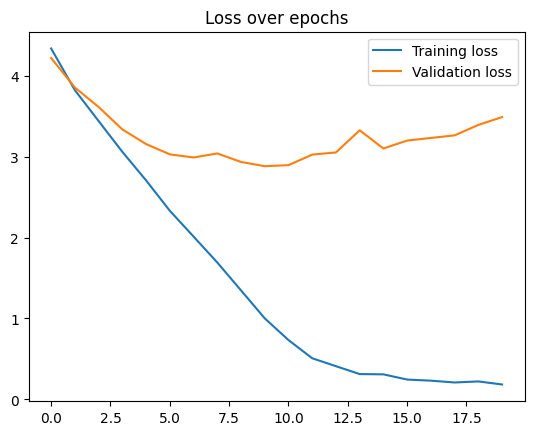

In [51]:
train(model_with_128_size_images, 20)

In [52]:
gap_score_model_with_128_size_images, df_with_confidence_loaded_model = calculate_gap(model_with_128_size_images, val_dataloader, unique_classes_train, device)

Evaluating model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:15<00:00,  7.49it/s]


In [53]:
print(f"Global Average Precision (GAP): {gap_score_model_with_128_size_images:.4f}")

Global Average Precision (GAP): 0.3336


In [54]:
torch.save(model_with_128_size_images.state_dict(), "models/transformer-20-epochs-128-size-8-batch-size")

In [82]:
all_landmarks_ids = pd.read_csv("eu_landmarks.csv", sep='\t')


In [83]:
all_landmarks_ids

,landmark_id
0,20298
1,19441
2,19459
3,19047
4,19053
...,...
14400,182733
14401,182779
14402,182780
14403,182781


In [75]:
all_landmarks_ids['landmark_id']

KeyError: 'landmark_id'